## Horses vs Humans.
This file will use Transfer Learning (InceptionV3) to train the detection between Horses and Humans pictures. and will stop when arrive to 97% of accuracy.

In [1]:
# import files
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from os import getcwd
import zipfile
import os
#import shuti

In [2]:
#import Model 
path_inception="inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
from tensorflow.keras.applications.inception_v3 import InceptionV3
local_weight_file=path_inception
pre_trained_model=InceptionV3( input_shape=(150,150,3),
                             include_top=False,
                             weights=None)
pre_trained_model.load_weights(local_weight_file)
for layer in pre_trained_model.layers:
    layer.trainable=False
pre_trained_model.summary()


Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [3]:
#define the last layer(output)
last_layers= pre_trained_model.get_layer("mixed7")
last_output=last_layers.output
print('last layer output shape: ', last_layers.output_shape)

last layer output shape:  (None, 7, 7, 768)


In [4]:
# to avoid crazy overfitting, we set accuracy around 95%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.97):            
            print("\nReached 97.0% accuracy so cancelling training!")
            self.model.stop_training = True

In [5]:
#model
from tensorflow.keras.optimizers import RMSprop
x = layers.Flatten()(last_output)
x = layers.Dense(1024,activation="relu")(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(1,activation="sigmoid")(x)
model= Model(pre_trained_model.input,x)
model.compile(optimizer=RMSprop(lr=0.0001),
              loss="binary_crossentropy", 
              metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [6]:
#Load train file
zip_file="horse-or-human.zip"
zip_ji= zipfile.ZipFile(zip_file,"r")
zip_ji.extractall("/horse-or-human/training")
zip_ji.close()

In [7]:
#Load validation file
zip_file="validation-horse-or-human.zip"
zip_ji= zipfile.ZipFile(zip_file,"r")
zip_ji.extractall("/horse-or-human/validation")
zip_ji.close()

In [8]:
# Define our directories and files
train_dir = '/horse-or-human/training'
validation_dir = '/horse-or-human/validation'

train_horses_dir = os.path.join(train_dir,"horses")
train_humans_dir = os.path.join(train_dir,"humans")
validation_horses_dir = os.path.join(validation_dir,"horses")
validation_humans_dir = os.path.join(validation_dir,"humans")

train_horses_fnames =os.listdir(train_horses_dir)
train_humans_fnames = os.listdir(train_humans_dir)
validation_horses_fnames = os.listdir(validation_horses_dir)
validation_humans_fnames = os.listdir(validation_humans_dir)

print(len(train_horses_fnames))
print(len(train_humans_fnames))
print(len(validation_horses_fnames))
print(len(validation_humans_fnames))


500
527
128
128


In [9]:
# create the "label" for the files
from tensorflow.keras.preprocessing.image import ImageDataGenerator

training_dir="/horse-or-human/training"
train_datagen= ImageDataGenerator(rescale=1/255,
    rotation_range=40,
    width_shift_range = 0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2)
train_generator=train_datagen.flow_from_directory(
    training_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode="binary")

test_dir="/horse-or-human/validation"
test_datagen = ImageDataGenerator(rescale=1/255)
validation_generator=test_datagen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode="binary")

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [10]:
callbacks= myCallback()
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=3,
    validation_data=validation_generator,
    validation_steps=20,
    verbose=2,
    callbacks=[callbacks])


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/3
100/100 - 151s - loss: 0.0957 - accuracy: 0.9628 - val_loss: 0.0417 - val_accuracy: 0.9823
Epoch 2/3

Reached 97.0% accuracy so cancelling training!
100/100 - 162s - loss: 0.0192 - accuracy: 0.9939 - val_loss: 0.0085 - val_accuracy: 0.9949


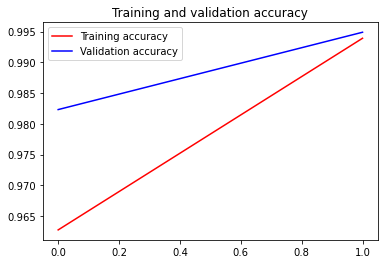

<Figure size 432x288 with 0 Axes>

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()